10.2.2 확률과정의 2번(제곱근 확산 모형) 참고

In [1]:
import numpy as np
from sn_random_numbers import sn_random_numbers
from simulation_class import simulation_class

# 16.5.1 시뮬레이션 클래스

In [2]:
class square_root_diffusion(simulation_class):
    ''' 콕스-잉거솔-로스의 제곱근 확산 모형에 기반한 시뮬레이션 경로 생성
    
    속성
    ====
    name : string
        객체 이름
    mar_env : instance of market_environment
        시뮬레이션에 필요한 시장 환경
    corr : Boolean
        다른 모형 객체와 상관관계가 있으면 True
    
    Method
    ======
    update :
        파라미터 갱신
    generate_paths :
        주어진 시장 환경에 따른 몬테카를로 경로 반환
    
    '''
    def __init__(self, name, mar_env, corr = False):
        super(square_root_diffusion, self).__init__(name, mar_env, corr)
        try:
            self.kappa = mar_env.get_constant('kappa')
            self.theta = mar_env.get_constant('theta')
        
        except:
            print('Error parsing market environment')
        
    def update(self, initial_value = None, volatility = None, kappa = None, theta = None, final_date = None):
        if initial_value is not None:
            self.initial_value = initial_value
        
        if volatility is not None:
            self.volatility = volatility
        
        if kappa is not None:
            self.kappa = kappa
        
        if theta is not None:
            self.theta = theta
        
        if final_date is not None:
            self.final_date = final_date
        
        self.instrument_values = None
    
    def generate_paths(self, fixed_seed = True, day_count = 365.):
        if self.time_grid is None:
            self.generate_time_grid()
        
        M = len(self.time_grid)
        I = self.paths
        paths = np.zeros((M, I))
        paths_ = np.zeros_like(paths)
        paths[0] = self.initial_value
        paths_[0] = self.initial_value
        if self.correlated is False:
            rand = sn_random_numbers((1, M, I), fixed_seed = fixed_seed)
        
        else:
            rand = self.random_numbers
        
        for t in range(1, len(self.time_grid)):
            dt = (self.time_grid[t] - self.time_grid[t-1]).days / day_count
            if self.correlated is False:
                ran = rand[t]
            
            else:
                ran = np.dot(self.cholesky_matrix, rand[:, t, :])
                ran = ran[self.rn_set]
            
            # full truncation 방식 오일러 이산화
            paths_[t] = (paths_[t-1] + self.kappa * (self.theta - np.maximum(0, paths_[t-1, :])) * dt
                        + np.sqrt(np.maximum(0, paths_[t-1, :])) * self.volatility * np.sqrt(dt) * ran)
            paths[t] = np.maximum(0, paths_[t])
        self.instrument_values = paths

# 16.5.2 사용 예

In [3]:
from dx_frame import *

In [4]:
# 시장 환경 설정
me_srd = market_environment('me_srd', dt.datetime(2015, 1, 1))
me_srd.add_constant('initial_value', .25)
me_srd.add_constant('volatility', 0.05)
me_srd.add_constant('final_date', dt.datetime(2015, 12, 31))
me_srd.add_constant('currency', 'EUR')
me_srd.add_constant('frequency', 'W')
me_srd.add_constant('paths', 10000)

In [5]:
# 제곱근 확산 모형에 필요한 시장 환경
me_srd.add_constant('kappa', 4.0)
me_srd.add_constant('theta', 0.2)

In [6]:
me_srd.add_curve('discount_curve', constant_short_rate('r', 0.0))

In [7]:
srd = square_root_diffusion('srd', me_srd)

In [8]:
srd_paths = srd.get_instrument_values()[:, :10]

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([16436., 16495., 16556., 16617., 16679., 16740., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

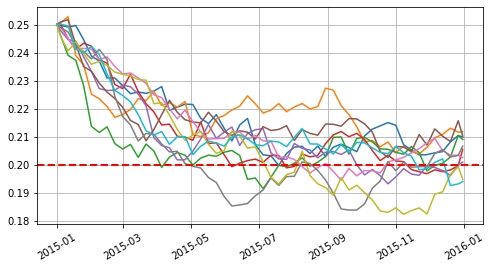

In [10]:
plt.figure(figsize = (8, 4))
plt.plot(srd.time_grid, srd_paths)
plt.axhline(me_srd.get_constant('theta'), color = 'r', ls = '--', lw = 2.0)
plt.grid(True)
plt.xticks(rotation = 30)